In [70]:
import torch
import pandas as pd
import numpy as np
import seaborn as sb
import torch.nn as nn
import torch.optim as optim

from matplotlib import pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tqdm import trange
from torch.utils.data import Dataset, DataLoader

In [6]:
df = pd.read_csv('../Data/HW2_data/international_matches.csv')

In [7]:
print(df.columns)

Index(['date', 'home_team', 'away_team', 'home_team_continent',
       'away_team_continent', 'home_team_fifa_rank', 'away_team_fifa_rank',
       'home_team_total_fifa_points', 'away_team_total_fifa_points',
       'home_team_score', 'away_team_score', 'tournament', 'city', 'country',
       'neutral_location', 'shoot_out', 'home_team_result',
       'home_team_goalkeeper_score', 'away_team_goalkeeper_score',
       'home_team_mean_defense_score', 'home_team_mean_offense_score',
       'home_team_mean_midfield_score', 'away_team_mean_defense_score',
       'away_team_mean_offense_score', 'away_team_mean_midfield_score'],
      dtype='object')


In [158]:
print(df['away_team_score'])

22434    0
15551    1
14666    0
20461    4
20200    0
        ..
15483    0
17693    0
16543    1
16014    4
21747    0
Name: away_team_score, Length: 9594, dtype: int64


In [9]:
result_color_map = { 
    "Win": "green",
    "Lose": "red",
    "Draw": "blue"
}
df['result_color'] = df['home_team_result'].map(result_color_map)

<AxesSubplot: xlabel='home_team_fifa_rank', ylabel='away_team_fifa_rank'>

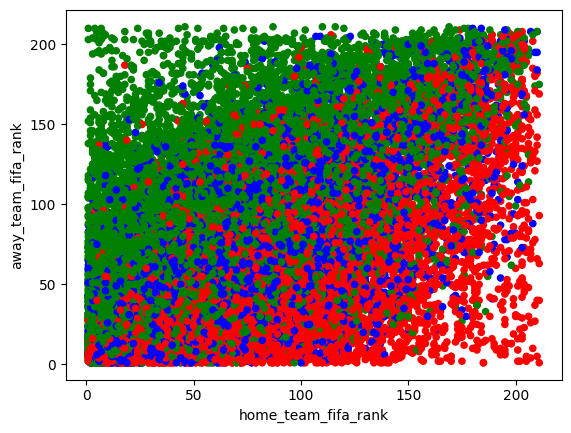

In [11]:
df.plot.scatter(
    x='home_team_fifa_rank', 
    y='away_team_fifa_rank', 
    c=df['result_color']
)

In [12]:
df = df[df['home_team_total_fifa_points'] > 0]
df = df[df['away_team_total_fifa_points'] > 0]

In [13]:
df = shuffle(df)
train, test = train_test_split(df, test_size=0.25)

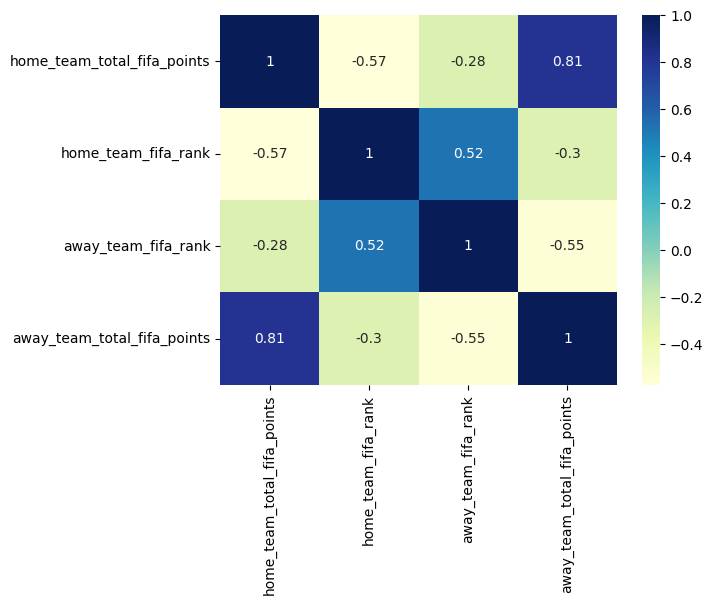

In [99]:
sub_df = df[['home_team_total_fifa_points', 
   'home_team_fifa_rank',
   'away_team_fifa_rank',
   'away_team_total_fifa_points'
]]

corrplot = sb.heatmap(sub_df.corr(), cmap='YlGnBu', annot=True)
plt.show()

In [134]:
feature_columns = ['home_team_total_fifa_points', 
   'home_team_fifa_rank',
   'away_team_fifa_rank',
   'away_team_total_fifa_points'
]

In [135]:
sub_df = train[feature_columns]



result_to_int_map = {
    "Win": 2,
    "Draw": 1,
    "Lose": 0
}
res_df = train[['home_team_result']]
res_df = res_df['home_team_result'].map(result_to_int_map)

In [136]:
train_x = np.array(sub_df.values.tolist(), dtype='float32')
train_y = np.array(res_df.values.tolist(), dtype='float32')
print(train_x.shape, train_y.shape)

(7195, 4) (7195,)


In [137]:
tsub_df = test[feature_columns]

tres_df = test[['home_team_result']]
tres_df = tres_df['home_team_result'].map(result_to_int_map)

test_x = np.array(tsub_df.values.tolist(), dtype='float32')
test_y = np.array(tres_df.values.tolist(), dtype='float32')

print(test_x.shape, test_y.shape)

(2399, 4) (2399,)


In [138]:
class CustomDataset(Dataset): 
    def __init__(self, X, y): 
        self.X = X 
        self.y = y
        
    def __len__(self): 
        return self.X.shape[0]
        
    def __getitem__(self, idx): 
        x = self.X[idx]
        label = self.y[idx]
                
        return torch.tensor(x), label

In [139]:
dataset = CustomDataset(
    train_x, 
    train_y
)

BATCH_SIZE=100

dataloader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

In [168]:
class TinyModel(nn.Module): 
    def __init__(self): 
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(4, 10),
            nn.ReLU(),
            nn.Linear(10, 20),
            nn.ReLU(),
            nn.Linear(20, 8),
            nn.ReLU(),
            nn.Linear(8, 20),
            nn.ReLU(),
            nn.Linear(20, 3)
        )
        
    def forward(self, x):
        return self.layers(x)

loss 1.00 accuracy 0.50: 100%|█████████████████| 22/22 [00:00<00:00, 506.31it/s]


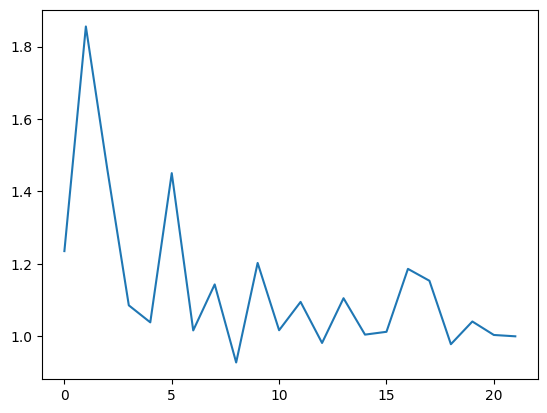

In [169]:
model = TinyModel()
sgd = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
loss_fn = nn.CrossEntropyLoss()

BATCH_SIZE = 100
epochs = 22

losses, accuracies = [], []

for i in (t := trange(epochs)): 
    
    epoch_loss = 0
    epoch_accuracy = 0
    all_count = 0
    
    for xs, labels in dataloader: 
        sgd.zero_grad()
        
        outs = model.forward(xs)
            
        loss = loss_fn(outs, labels.type(torch.LongTensor))
        loss.backward()
        
        sgd.step()
        
        cat = np.argmax(outs.data, axis=1)
                
        epoch_loss += loss.data
        epoch_accuracy += (cat == labels).sum().data
        all_count += xs.shape[0]
        
        break

    acc = epoch_accuracy.data / all_count
        
    losses.append(epoch_loss)
    accuracies.append(acc)
    t.set_description("loss %.2f accuracy %.2f" % (epoch_loss, acc))

    
plt.plot([x for x in range(epochs)], losses)


    

In [170]:
print(test_x.shape)
t_test_x = torch.tensor(test_x.astype('float32'))
test_pred = model.forward(t_test_x)
t_test_y = torch.tensor(test_y)

print("test loss is, ", loss_fn(test_pred, t_test_y.type(torch.LongTensor)).data)
cat = np.argmax(test_pred.data, axis=1)

                
test_acc = (cat == t_test_y).sum()
print("test acc is, ", test_acc / t_test_y.shape[0])

(2399, 4)
test loss is,  tensor(0.9625)
test acc is,  tensor(0.5573)


In [180]:
# ['home_team_total_fifa_points',
#  'home_team_fifa_rank', 
#   'away_team_fifa_rank', 
#   'away_team_total_fifa_points']

iran_wales_features = torch.tensor([1564.61, 20, 19, 1569.82])
iran_england_features = torch.tensor([1564.61, 20, 5, 1728.47])
iran_us_features = torch.tensor([1564.61, 20, 16, 1627.48])

pred = model.forward(iran_wales_features)
print(np.argmax(pred.data))

pred = model.forward(iran_england_features)
print(np.argmax(pred.data))

pred = model.forward(iran_us_features)
print(np.argmax(pred.data))

tensor(2)
tensor(2)
tensor(2)


This means my model predicts Iran will lose all its matches in Fifa world cup, because their team rank and fifa scores are better. 